<a href="https://colab.research.google.com/github/rachit2005/Large-Language-Model/blob/main/makemore_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

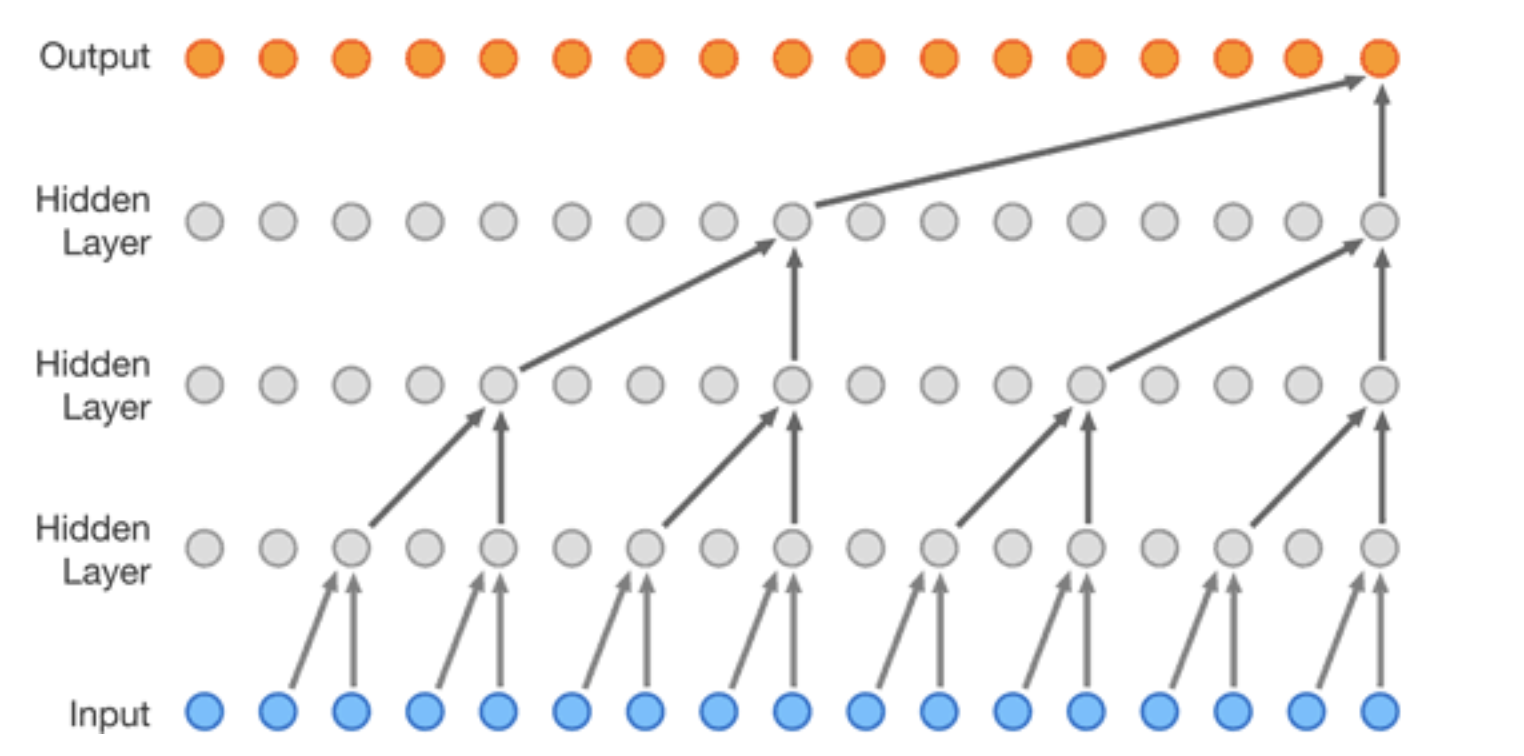

In [77]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Wavenet model

In [78]:
import requests
url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"
resp = requests.get(url)
words = resp.text.splitlines()

In [79]:
# building vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [80]:
# build dataset

block_size = 8

def build_dataset(words):
  x , y = [] , []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      x.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  x = torch.tensor(x)
  y = torch.tensor(y)
  print(x.shape , y.shape)
  return x , y

n1 , n2 = int(0.8*len(words)), int(0.9*len(words))
xtr , ytr = build_dataset(words[:n1])
xdev , ydev = build_dataset(words[n1:n2])
xtre , ytre = build_dataset(words[n2:])

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [81]:
for x , y in zip(xtr[:5] , ytr[:5]):
  print(''.join(itos[i.item()] for i in x) , '---->' , itos[y.item()])

........ ----> e
.......e ----> m
......em ----> m
.....emm ----> a
....emma ----> .


In [82]:
class Linear:
  def __init__(self , fan_in , fan_out , bias=True):
    self.weights = torch.randn((fan_in , fan_out)) / (fan_in**0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, X):
    self.out = X @ self.weights
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1D:
  def __init__(self , dim , eps=1e-5 , momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # train with backpropagation
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,X):
    # cal forward pass
    if self.training:
      if X.ndim == 2:
        dim = 0
      elif X.ndim ==3:
        dim = (0,1)
      mean = X.mean(dim , keepdim=True)
      std = X.std(dim , keepdim=True)
    else:
      mean = self.running_mean
      std = self.running_var

    xhat = (X - mean)/torch.sqrt(std + self.eps) # normalise to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffer
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * std

    return self.out

  def parameters(self):
    return [self.gamma , self.beta]

class Tanh():
  def __call__(self , X):
    self.out = torch.tanh(X)
    return self.out

  def parameters(self):
    return []


class Embedding:
  def __init__(self , num_embeddings , embedding_dim):
    self.weights = torch.randn(num_embeddings , embedding_dim)

  def __call__(self , X):
    self.out = self.weights[X]
    return self.out

  def parameters(self):
    return [self.weights]

class Flatten:
  def __init__(self , n):
    self.n = n # no of consecutive element that we like to concatenate at the last dim of the output

  def __call__(self ,x):
    B,T,C = x.shape
    x = x.view(B , T//self.n , C*self.n)

    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x

    return self.out

  def parameters(self):
    return []


class Sequential:
  def __init__(self , layers):
    self.layers = layers

  def __call__(self, X):
    for layer in self.layers:
      X = layer(X)

    self.out = X
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [83]:
n_emd =24
n_hidden =128
g = torch.Generator().manual_seed(2147483647)

# C = torch.randn((vocab_size , n_emd) , generator=g)
model = Sequential([
          Embedding(vocab_size , n_emd), # [32 , 8 , 24]
          Flatten(2), #output -->  [32 , 4 , 20]
          Linear(n_emd*2 , n_hidden , bias=False),BatchNorm1D(n_hidden) ,Tanh(), # output --> [32 , 4 , 128]
          Flatten(2), # output --> [32 , 2 , 400]
          Linear(n_hidden*2 , n_hidden , bias=False),BatchNorm1D(n_hidden) ,Tanh(), # [32 , 2 , 200]
          Flatten(2), # output --> [32 , 400]
          Linear(n_hidden*2 , n_hidden , bias=False),BatchNorm1D(n_hidden) ,Tanh(), # [32, 200]
          Linear(n_hidden , vocab_size ) # [32 , 27]
])

with torch.no_grad():
  model.layers[-1].weights *= 0.01


parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

In [84]:
ix = torch.randint(0 , xtr.shape[0] , (32,))
xb , yb = xtr[ix] , ytr[ix]

print(xb.shape)
for layer in model.layers:
  xb = layer(xb)
  print(layer.__class__.__name__, ' : ' , xb.shape)

print(xb.squeeze(1).shape)

torch.Size([32, 8])
Embedding  :  torch.Size([32, 8, 24])
Flatten  :  torch.Size([32, 4, 48])
Linear  :  torch.Size([32, 4, 128])
BatchNorm1D  :  torch.Size([32, 4, 128])
Tanh  :  torch.Size([32, 4, 128])
Flatten  :  torch.Size([32, 2, 256])
Linear  :  torch.Size([32, 2, 128])
BatchNorm1D  :  torch.Size([32, 2, 128])
Tanh  :  torch.Size([32, 2, 128])
Flatten  :  torch.Size([32, 256])
Linear  :  torch.Size([32, 128])
BatchNorm1D  :  torch.Size([32, 128])
Tanh  :  torch.Size([32, 128])
Linear  :  torch.Size([32, 27])
torch.Size([32, 27])


In [86]:
# same optimization as last time
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, xtr.shape[0], (batch_size,))
  Xb, Yb = xtr[ix], ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

      0/ 200000: 1.8015
  10000/ 200000: 2.2469
  20000/ 200000: 1.9232
  30000/ 200000: 1.4445
  40000/ 200000: 2.1242
  50000/ 200000: 1.9671
  60000/ 200000: 2.0947
  70000/ 200000: 2.2988
  80000/ 200000: 1.4626
  90000/ 200000: 2.1214
 100000/ 200000: 1.6311
 110000/ 200000: 2.0803
 120000/ 200000: 1.5720
 130000/ 200000: 1.9266
 140000/ 200000: 2.1974
 150000/ 200000: 1.8989
 160000/ 200000: 1.8288
 170000/ 200000: 1.9986
 180000/ 200000: 1.7518
 190000/ 200000: 1.3522


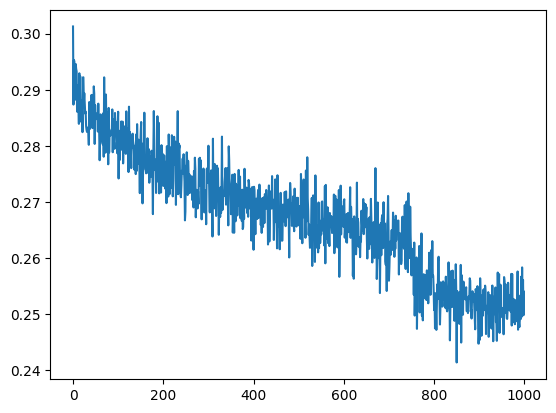

In [87]:
plt.plot(torch.tensor(losses).view(1000,-1).mean(1))

In [88]:
for layer in model.layers:
  layer.training = False

@torch.no_grad()

def split_loss(split):
  x,y = {
      'train': (xtr, ytr),
      'val': (xdev, ydev),
      'test': (xtre, ytre),
  }[split]
  logits = model(x)

  loss = F.cross_entropy(logits , y)
  print(split , ' : ',loss.item())

split_loss('train')
split_loss('val')

train  :  1.765101671218872
val  :  2.2548751831054688


In [89]:
# sample generation form the model

for _ in range(20):
  context = [0]*block_size
  out = []

  while True:
    # forward pass
    logits = model(torch.tensor([context]))

    probs = F.softmax(logits , dim=1)
    # sample from distribution
    ix = torch.multinomial(probs , num_samples=1,).item()

    # shift the context window and track the sample
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

paezleigh.
sammire.
jaxx.
casya.
zareerah.
kemimi.
valeesia.
alezyah.
marisa.
rainiella.
kolten.
clainish.
calmu.
renrnold.
laney.
rhye.
stantind.
bothalynn.
betsee.
anifer.
